In [ ]:
import numpy as np
import pandas as pd
from scipy.signal import hilbert


def get_delay(phase):
    """
    Computes the overall delay for a all given channels

    Parameters
    ----------
    phase : numpy.ndarray
        m x n ndarray : m: number of channels, n: number of samples

    Returns
    -------
    delay : int
    """
    phase = phase
    m, n = phase.shape
    c1 = n*(m-2)
    r_phase = np.roll(phase, 2, axis=0)
    m = np.multiply(phase, r_phase)[1:-1]
    c2 = (m < 0).sum()
    delay = int(np.round(c1/c2))
    return delay


def get_phase(time_series):
    """
    Computes phase from time series using a hilbert transform and computing the angles between the real and imaginary part for each sample

    Parameters
    ----------
    time_series : numpy.ndarray
        m x n ndarray : m: number of channels, n: number of samples

    Returns
    -------
    phase : numpy.ndarray
        m x n ndarray : m: number of channels, n: number of samples
    """

    complex_series = hilbert(time_series, axis=0)
    phase = np.angle(complex_series)
    return phase

def get_discretized_phase(phase, binsize):
    """
    Discretizes the phase series to rectangular bins

    Parameters
    ----------
    phase : numpy.ndarray
        m x n ndarray : m: number of channels, n: number of samples

    binsize : float

    Returns
    -------
    d_phase : numpy.ndarray
        m x n ndarray : m: number of channels, n: number of samples

    """
    d_phase = np.ceil(phase / binsize).astype(np.int32)
    return d_phase


def get_binsize(phase, c = 3.49):
    """
    Computes the bin size for the phase binning

    Parameters
    ----------
    c : float
    phase : numpy.ndarray
        m x n ndarray : m: number of channels, n: number of samples

    Returns
    -------
    bincount : float

    """

    m, n = phase.shape
    binsize = c * np.mean(np.std(phase, axis=0, ddof=1)) * m ** (-1.0 / 3)
    return binsize

def get_bincount(binsize):
    """
    Get bin count for the interval [0, 2*pi] for given binsize

    Parameters
    ----------
    binsize : float

    Returns
    -------
    bincount : int

    """
    bins_w = np.arange(0, 2 * np.pi, binsize)
    bincount = len(bins_w)
    return bincount


def compute_PTE(phase, delay):
    """
    For each channel pair (x, y) containing the individual discretized phase, which is obtained by pyPTE.pyPTE.get_discretized_phase,
    this function performs the entropy estimation by counting the occurences of phase values in x, y and y_predicted,
    which is achieved by slicing the x, y to consider delay x samples in the past and delay samples in the future.

    Parameters
    ----------
    phase : numpy.ndarray
         m x n ndarray : m: number of channels, n: number of samples
    delay : int
        This is the analysis delta, which is the number of samples in the past to be considered for x and y
        Momentarily delay is estimated by pyPTE.pyPTE.get_delay(). A custom delay estimation can be used as well.

    Returns
    -------
    PTE : numpy.ndarray
        m x m matrix containing the PTE value for each channel pair
    """
    m, n = phase.shape
    PTE = np.zeros((n,n), dtype=float)

    for i in range(0, n):
        for j in range(0, n):

            ypr = phase[delay:, j]
            y = phase[:-delay, j]
            x = phase[:-delay, i]

            P_y = np.zeros([y.max() +1])
            np.add.at(P_y, [y], 1)

            P_ypr_y = np.zeros([ypr.max()+1, y.max()+1])
            np.add.at(P_ypr_y, [ypr, y], 1)

            P_y_x = np.zeros([y.max()+1, x.max()+1])
            np.add.at(P_y_x, [y, x], 1)

            P_ypr_y_x = np.zeros([ypr.max()+1, y.max()+1, x.max()+1])
            np.add.at(P_ypr_y_x, [ypr, y, x], 1)

            P_y /= (m-delay)
            P_ypr_y /= (m-delay)
            P_y_x /= (m-delay)
            P_ypr_y_x /= (m-delay)

            Hy = -np.nansum(np.multiply(P_y,np.log2(P_y)))
            Hypr_y = - np.nansum(np.nansum(np.multiply(P_ypr_y, np.log2(P_ypr_y))))
            Hy_x = -np.nansum(np.nansum(np.multiply(P_y_x, np.log2(P_y_x))))
            Hypr_y_x = -np.nansum(np.nansum(np.nansum(np.multiply(P_ypr_y_x, np.log2(P_ypr_y_x)))))
            PTE[i, j] = Hypr_y + Hy_x - Hy - Hypr_y_x
    return PTE

def compute_dPTE_rawPTE(phase, delay):
    """
    This function calls pyPTE.pyPTE.compute_PTE to obtain a PTE matrix and
    performs a normalization yielding dPTE to easily investigate directionality information.
    Technically it could be a function which computes the normalization for a given PTE matrix, but it appears to be
    more convenient to obtain both matrices in one call

    Parameters
    ----------
    phase : numpy.ndarray
        m x n ndarray : m: number of channels, n: number of samples
        The discretized phase is computed by pyPTE.pyPTE.get_discretized_phase

    delay : int
        This is the analysis delta, which is the number of samples in the past to be considered for x and y
        Momentarily delay is estimated by pyPTE.pyPTE.get_delay(). A custom delay estimation can be used as well.

    Returns
    -------
    (dPTE, raw_PTE) : tuple of numpy.ndarray objects
        dPTE : normalized PTE matrix, raw_PTE: original PTE values

    """
    raw_PTE = compute_PTE(phase, delay)

    tmp = np.triu(raw_PTE) + np.tril(raw_PTE).T
    with np.errstate(divide='ignore',invalid='ignore'):
        dPTE = np.triu(raw_PTE/tmp,1) + np.tril(raw_PTE/tmp.T,-1)
    return dPTE, raw_PTE

def PTE(time_series):
    """
    This function performs the whole procedure of calculating the PTE:
    1. Compute the phase by applying the Hilbert transform on the time-series and calculate the angle between
    the real and imaginary part. The phase is defined on the interval [-pi, pi[
    2. Estimate the analysis delay
    3. For ease of binning shift the phase along the ordinate so there are no negative values
    4. Calculate the binsize in number of samples
    5. Bin the phase data
    6. Compute the dPTE and raw_PTE

    Parameters
    ----------
    time_series : numpy.ndarray
        m x n ndarray : m: number of channels, n: number of samples

    Returns
    -------
    (dPTE, raw_PTE) : tuple of numpy.ndarray objects
        dPTE : normalized PTE matrix, raw_PTE: original PTE values

    """
    phase = get_phase(time_series)
    delay = get_delay(phase)
    phase_inc = phase + np.pi
    binsize = get_binsize(phase_inc)
    d_phase = get_discretized_phase(phase_inc, binsize)

    return compute_dPTE_rawPTE(d_phase, delay)

def PTE_from_dataframe(data_frame):
    """
    This is a wrapper which allows calculating dPTE,PTE matrices by passing an pandas.DataFrame

    Parameters
    ----------
    data_frame : pandas.DataFrame
        This object contains time-series data where pandas.DataFrame.index corresponds to the time samples and
        pandas.DataFrame.columns represents the individual channels

    Returns
    -------
    (dPTE_df, rPTE_df) : tuple of pandas.DataFrame objects
        The results from pyPTE.pyPTE.PTE are stored as pandas.DataFrames, while it is indexed in two dimensions by
        pandas.DataFrame.columns of the input

    """
    time_series = data_frame.as_matrix()
    dPTE, rPTE = PTE(time_series)
    dPTE_df = pd.DataFrame(dPTE, index=data_frame.columns, columns=data_frame.columns)
    rPTE_df = pd.DataFrame(rPTE, index=data_frame.columns, columns=data_frame.columns)
    return dPTE_df, rPTE_df

In [34]:
tmp_head = np.zeros(64)

In [36]:
ctrl_mt = pd.read_csv('/Users/jiangzifan/Desktop/pfc06_t1', names = tmp_head)
ctrl_mt

,0.0,0.0.1,0.0.2,0.0.3,0.0.4,0.0.5,0.0.6,0.0.7,0.0.8,0.0.9,...,0.0.54,0.0.55,0.0.56,0.0.57,0.0.58,0.0.59,0.0.60,0.0.61,0.0.62,0.0.63
0,-4.83140,2.51720,-3.709800,2.73440,2.323700,6.17110,10.5210,11.43200,8.261600,3.80360,...,-3.75310,-2.00370,0.67351,1.83060,0.450620,0.796690,7.823000,3.77300,0.759390,5.47180
1,-12.98700,-1.15490,-11.380000,0.65502,-1.870000,6.33780,17.1150,24.53300,15.858000,3.74760,...,-8.51300,-2.28970,4.82910,4.71910,0.978400,-0.058366,12.637000,6.74160,0.147490,10.97500
2,-12.43000,0.46201,-11.510000,-1.97560,-2.631100,7.50980,19.2910,26.37600,18.737000,5.64990,...,-14.37700,-6.44430,4.27500,5.08930,1.975000,-6.884000,10.761000,9.96970,0.038479,10.30100
3,-9.19240,5.11320,-9.808900,-6.67470,-1.775300,10.87000,22.5640,26.43100,21.351000,9.53070,...,-20.80800,-13.99800,1.17070,4.42010,3.135300,-17.561000,2.875900,12.66100,1.316200,4.61410
4,-11.55100,4.84770,-12.437000,-10.32600,-1.813400,12.22500,24.8940,28.95700,23.014000,12.42200,...,-24.23800,-18.57000,0.91324,5.01190,3.467500,-20.649000,0.499980,13.37500,3.120700,2.95360
5,-16.75200,-1.20790,-15.068000,-7.84010,-0.958660,8.75020,20.0580,26.70200,18.656000,12.57700,...,-21.43600,-17.77400,0.41854,3.80300,2.155500,-12.141000,9.335500,11.87000,4.613600,7.05750
6,-16.69700,-5.84510,-11.245000,-0.66127,2.815400,3.97660,10.0820,17.22300,10.046000,11.38500,...,-14.75000,-16.28900,-5.73140,-1.69010,0.010217,-3.339400,19.006000,9.75260,5.558100,8.82230
7,-11.73000,-4.10460,-4.920800,2.55480,5.284200,3.11040,6.4442,12.02200,5.893600,8.15170,...,-10.58700,-18.13300,-14.45200,-7.59960,-0.897410,-5.845700,16.858000,8.13620,5.461300,3.19190
8,-8.93080,1.14290,-3.955500,-1.76950,2.059100,6.50180,14.5800,19.94800,10.394000,1.58360,...,-11.81900,-21.98100,-19.31400,-9.68580,0.164330,-15.008000,7.626200,7.57120,5.426300,-4.26410
9,-8.63200,4.91460,-5.381000,-5.08070,-1.416400,10.29200,23.8930,30.39200,17.271000,-3.11460,...,-14.28500,-23.61400,-18.60400,-8.64910,1.237200,-16.761000,6.530300,9.11900,8.009100,-5.16350


TypeError: descriptor 'transpose' requires a 'numpy.ndarray' object but received a 'DataFrame'

In [37]:
PTE1, PTE2 = PTE(ctrl_mt)

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:137: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:140: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:143: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a diff

In [38]:
PTE1

array([[0.        , 0.5240559 , 0.44927042, ..., 0.50900934, 0.43866319,
        0.50004009],
       [0.4759441 , 0.        , 0.48543648, ..., 0.45281893, 0.46093723,
        0.48162122],
       [0.55072958, 0.51456352, 0.        , ..., 0.49042598, 0.45960079,
        0.49471784],
       ...,
       [0.49099066, 0.54718107, 0.50957402, ..., 0.        , 0.47618961,
        0.53333386],
       [0.56133681, 0.53906277, 0.54039921, ..., 0.52381039, 0.        ,
        0.4992012 ],
       [0.49995991, 0.51837878, 0.50528216, ..., 0.46666614, 0.5007988 ,
        0.        ]])

In [39]:
import matplotlib.pyplot as plt
import networkx as nx

def show_graph_with_labels(adjacency_matrix):
    rows, cols = np.where(adjacency_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    gr.add_edges_from(edges)
    nx.draw(gr, node_size=500)
    plt.show()

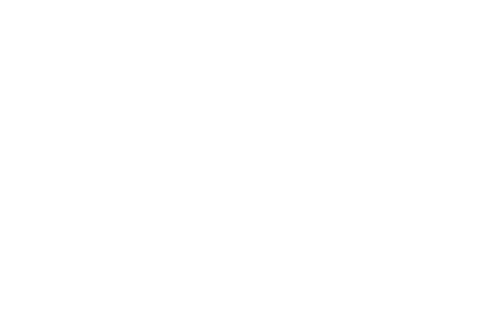

In [46]:
show_graph_with_labels(PTE1[:])

In [51]:
PTEdf = pd.DataFrame(PTE1)

In [52]:
PTEdf.to_csv('PTE1_ctrl01_t1.csv')

In [55]:
PTEdf

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.000000,0.524056,0.449270,0.510220,0.503469,0.542152,0.472848,0.448589,0.508212,0.478916,...,0.446948,0.463959,0.561584,0.561658,0.442628,0.504183,0.522943,0.509009,0.438663,0.500040
1,0.475944,0.000000,0.485436,0.415814,0.423502,0.514662,0.461058,0.485184,0.490409,0.470294,...,0.422999,0.501074,0.529678,0.530278,0.418193,0.538983,0.456682,0.452819,0.460937,0.481621
2,0.550730,0.514564,0.000000,0.544482,0.523690,0.520359,0.427289,0.494601,0.520278,0.502625,...,0.439689,0.470992,0.543343,0.568773,0.427370,0.520844,0.528185,0.490426,0.459601,0.494718
3,0.489780,0.584186,0.455518,0.000000,0.495829,0.507479,0.514282,0.500269,0.557209,0.465459,...,0.505366,0.511386,0.471563,0.541391,0.474851,0.601670,0.497417,0.506122,0.504082,0.514125
4,0.496531,0.576498,0.476310,0.504171,0.000000,0.503786,0.452707,0.484905,0.491283,0.437259,...,0.523923,0.435310,0.487942,0.534291,0.490495,0.545139,0.477263,0.477551,0.479926,0.482076
5,0.457848,0.485338,0.479641,0.492521,0.496214,0.000000,0.552752,0.480893,0.522866,0.482128,...,0.455745,0.463304,0.514637,0.526943,0.414844,0.560183,0.444663,0.449932,0.450964,0.543442
6,0.527152,0.538942,0.572711,0.485718,0.547293,0.447248,0.000000,0.510093,0.562081,0.446748,...,0.468658,0.451375,0.564975,0.516207,0.511978,0.516696,0.497766,0.493283,0.521024,0.517902
7,0.551411,0.514816,0.505399,0.499731,0.515095,0.519107,0.489907,0.000000,0.550738,0.485291,...,0.479063,0.421949,0.540229,0.592435,0.466190,0.525159,0.515405,0.525168,0.491182,0.512008
8,0.491788,0.509591,0.479722,0.442791,0.508717,0.477134,0.437919,0.449262,0.000000,0.452222,...,0.424868,0.463349,0.474437,0.525973,0.389212,0.549684,0.487184,0.499756,0.496689,0.517969
9,0.521084,0.529706,0.497375,0.534541,0.562741,0.517872,0.553252,0.514709,0.547778,0.000000,...,0.485325,0.497374,0.531513,0.509516,0.506646,0.527998,0.552558,0.501005,0.495990,0.540946
